In [19]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

from sequential_ft_transformer.fttransformer import ft_transformer
from sequential_ft_transformer.preprocessing import sq_df_to_dataset, download_data
from sequential_ft_transformer.plotting import plot_importances, plot_training_hist


## Download Data

In [20]:
data_folder = "../data/"
seq_length = 5
seq_col_name = "id"

In [21]:
input_url = "/kaggle/input/bank-credit-default-loan-default/data/train_data/train_data_0.pq.zip"
target_url = "/kaggle/input/bank-credit-default-loan-default/target.csv.zip"
input_file_name = "train_data_0.pq"
target_file_name = "target.csv"


download_data(input_url, data_folder, input_file_name)
download_data(target_url, data_folder, target_file_name)

input_df = pd.read_parquet(os.path.join(data_folder, input_file_name))
target_df = pd.read_csv(os.path.join(data_folder, target_file_name))

input_df = input_df.astype("int32")
target_df = target_df.astype("int32")

train_data_0.pq already exists in ../data/
target.csv already exists in ../data/


In [22]:
input_df = input_df.sort_values(by=[seq_col_name, "rn"])
target_df = target_df.sort_values(by=[seq_col_name])

In [23]:
DATASET_LIMIT = 1000
target_df = target_df.iloc[:DATASET_LIMIT]

In [24]:
max_id = np.max(target_df[seq_col_name].values)

In [25]:
input_df = input_df[input_df[seq_col_name] <= max_id]

## Preprocess

In [26]:
# Column information
NUMERIC_FEATURES = [
    'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
    'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
    'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
    'pre_loans_outstanding', 'pre_loans_total_overdue',
    'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
    'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
    'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
    'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
    'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
    'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
    'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
    'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
    'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
    'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
    'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24',
    'enc_loans_account_holder_type',
    'pclose_flag',
    'fclose_flag'
]
NUMERIC_FEATURES = sorted(NUMERIC_FEATURES)
CATEGORICAL_FEATURES = [
    'enc_loans_credit_status', 'enc_loans_account_cur',
    'enc_loans_credit_type',
]
CATEGORICAL_FEATURES = sorted(CATEGORICAL_FEATURES)

FEATURES = sorted(list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES))
LABEL = 'flag'

In [27]:
train_labels, test_labels = train_test_split(target_df, test_size=0.2)

train_input = input_df[input_df[seq_col_name].isin(train_labels[seq_col_name])]
test_input = input_df[input_df[seq_col_name].isin(test_labels[seq_col_name])]

## Get Lookup Tables for Each Categorical Column

In [28]:
cat_lookups = dict()
feature_unique_counts = dict()
num_oov_indices = 1
for cat in CATEGORICAL_FEATURES:
    unique_values = list(np.unique(train_input[cat]).astype(str))
    feature_unique_counts[cat] = len(unique_values) + num_oov_indices
    lookup = tf.keras.layers.StringLookup(vocabulary=unique_values, num_oov_indices=num_oov_indices)
    cat_lookups[cat] = lookup

In [29]:
feature_unique_counts

{'enc_loans_account_cur': 3,
 'enc_loans_credit_status': 6,
 'enc_loans_credit_type': 7}

## Convert Each Categorical String to an ID

In [30]:
for cat in CATEGORICAL_FEATURES:
    train_input[cat] = cat_lookups[cat](train_input[cat].to_numpy().astype(str))
    test_input[cat] = cat_lookups[cat](test_input[cat].to_numpy().astype(str))

/tmp/ipykernel_38638/2487444970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_input[cat] = cat_lookups[cat](train_input[cat].to_numpy().astype(str))
/tmp/ipykernel_38638/2487444970.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_input[cat] = cat_lookups[cat](test_input[cat].to_numpy().astype(str))


In [31]:
train_input.loc[:, CATEGORICAL_FEATURES] = train_input[CATEGORICAL_FEATURES].astype(int)
test_input.loc[:, CATEGORICAL_FEATURES] = test_input[CATEGORICAL_FEATURES].astype(int)

train_input.loc[:, NUMERIC_FEATURES] = train_input[NUMERIC_FEATURES].astype(float)
test_input.loc[:, NUMERIC_FEATURES] = test_input[NUMERIC_FEATURES].astype(float)

In [32]:
y_train, y_val = train_test_split(train_labels, test_size=0.2)

x_train = train_input[train_input[seq_col_name].isin(y_train[seq_col_name])]
x_val = train_input[train_input[seq_col_name].isin(y_val[seq_col_name])]

## Modelling Prep

In [33]:
# Make sure the target and input are in the same order
x_train = x_train.sort_values(by=[seq_col_name, "rn"])
x_val = x_val.sort_values(by=[seq_col_name, "rn"])
test_input = test_input.sort_values(by=[seq_col_name, "rn"])

y_train = y_train.sort_values(by=[seq_col_name])
y_val = y_val.sort_values(by=[seq_col_name])
test_labels = test_labels.sort_values(by=[seq_col_name])

In [34]:
batch_size = 10
train_dataset = sq_df_to_dataset(
    x_train, 
    seq_length, 
    seq_col_name=seq_col_name,
    target_df=y_train, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    batch_size=batch_size
)
val_dataset = sq_df_to_dataset(
    x_val, 
    seq_length, 
    seq_col_name=seq_col_name,
    target_df=y_val, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, # No shuffle
    batch_size=batch_size
)  
test_dataset = sq_df_to_dataset(
    test_input, 
    seq_length, 
    seq_col_name=seq_col_name,
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, 
    batch_size=batch_size) # No target, no shuffle

## Sequential FT-Transformer

In [35]:
# Explanations need to be set to false until the following bug is fixed: https://github.com/keras-team/keras/issues/19303
EXPLANATIONS = False 
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
N_BINS = 10
NUM_EPOCHS = 1000

# Pass the encoder to the model
model = ft_transformer(
    out_dim=1,
    out_activation='sigmoid',
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    feature_unique_counts = feature_unique_counts,
    seq_length=seq_length,
    numerical_embedding_type='linear',
    n_bins=N_BINS,
    explainable=EXPLANATIONS
)


optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

loss_dict = {"output": keras.losses.BinaryCrossentropy()}
metrics_dict = {"output": [keras.metrics.AUC(name="PR AUC", curve='PR')]}
if EXPLANATIONS:
    loss_dict.update({"importances": None})
    metrics_dict.update({"importances": None})
model.compile(
    optimizer = optimizer,
    loss = loss_dict,
    metrics= metrics_dict,
)

early = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

In [36]:
hist = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/1000


2024-01-20 13:57:06.680631: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inFT-Transformer/sequential_4/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-20 13:57:08.605092: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2fa04b2870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-20 13:57:08.605154: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-01-20 13:57:08.615060: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-20 13:57:08.643487: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1705751828.716880   38774 device_compiler

64/64 [==============================] - 17s 99ms/step - loss: 0.2024 - output_loss: 0.2024 - output_PR AUC: 0.0576 - val_loss: 0.1478 - val_output_loss: 0.1478 - val_output_PR AUC: 0.0290
Epoch 2/1000
64/64 [==============================] - 5s 76ms/step - loss: 0.1704 - output_loss: 0.1704 - output_PR AUC: 0.0633 - val_loss: 0.1585 - val_output_loss: 0.1585 - val_output_PR AUC: 0.0312
Epoch 3/1000
64/64 [==============================] - 5s 75ms/step - loss: 0.1752 - output_loss: 0.1752 - output_PR AUC: 0.0388 - val_loss: 0.1386 - val_output_loss: 0.1386 - val_output_PR AUC: 0.0323
Epoch 4/1000
64/64 [==============================] - 5s 80ms/step - loss: 0.1734 - output_loss: 0.1734 - output_PR AUC: 0.0386 - val_loss: 0.1500 - val_output_loss: 0.1500 - val_output_PR AUC: 0.0255
Epoch 5/1000
64/64 [==============================] - 5s 78ms/step - loss: 0.1738 - output_loss: 0.1738 - output_PR AUC: 0.0360 - val_loss: 0.1413 - val_output_loss: 0.1413 - val_output_PR AUC: 0.0267
Epoch 6

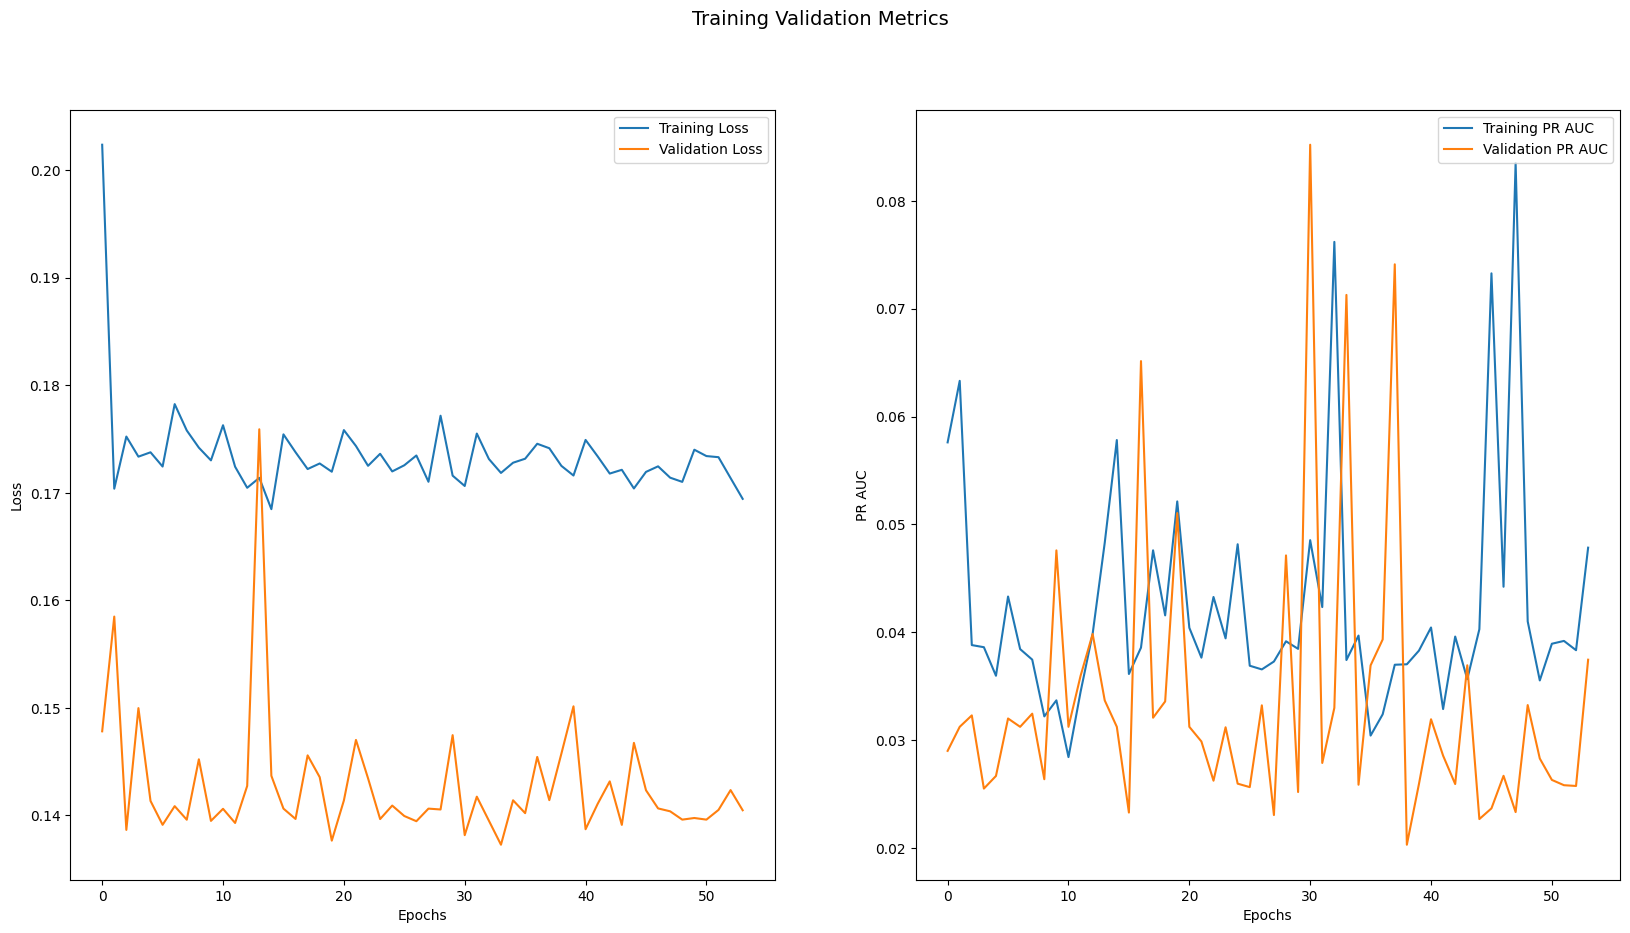

In [37]:
hist_plot = plot_training_hist(hist.history, EXPLANATIONS)

In [38]:
preds = model.predict(test_dataset)
print("Test ROC AUC:", np.round(roc_auc_score(test_labels[LABEL], preds['output'].ravel()), 4))
print("Test PR AUC:", np.round(average_precision_score(test_labels[LABEL], preds['output'].ravel()), 4))
print("Test Accuracy:", np.round(accuracy_score(test_labels[LABEL], preds['output'].ravel()>0.5), 4))

20/20 [==============================] - 1s 26ms/step
Test ROC AUC: 0.5306
Test PR AUC: 0.117
Test Accuracy: 0.98


## Explainability

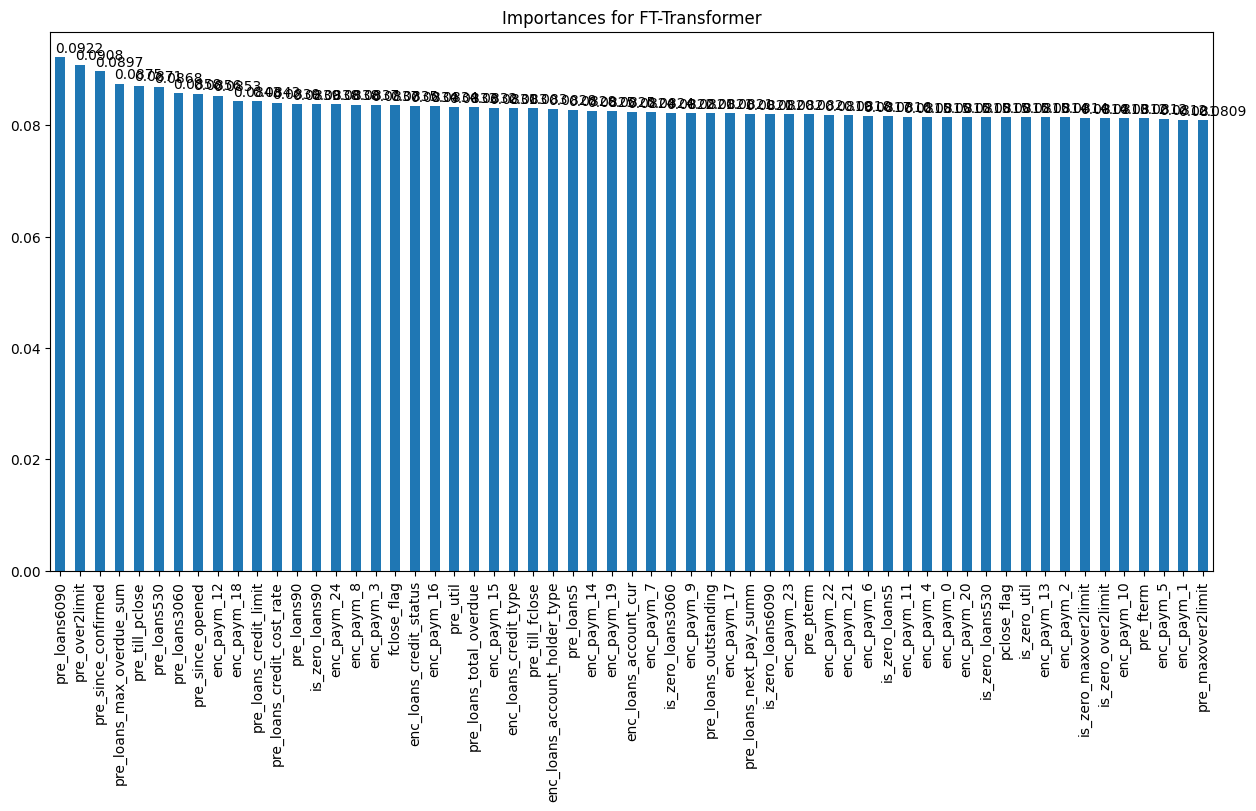

In [39]:
if 'importances' in preds.keys():
    importances = preds['importances']
    importances_df = pd.DataFrame(importances[:, :-1], columns = FEATURES)
    importances_fig, total_importances = plot_importances(
        importances_df, 
        title="Importances for FT-Transformer"
    )